In [86]:
%matplotlib inline

In [128]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from feature_engine import missing_data_imputers as mdi
from feature_engine import discretisers as dsc
from feature_engine import categorical_encoders as ce
import matplotlib.pyplot as plt

pd.pandas.set_option('display.max_columns', None)
Path.ls=lambda x: list(x.iterdir())

In [88]:
path_data=Path(r'D:\datasets\new_datasets')
list(path_data.iterdir())

[WindowsPath('D:/datasets/new_datasets/caterpillar-tube-pricing'),
 WindowsPath('D:/datasets/new_datasets/costa-rican-household-poverty-prediction'),
 WindowsPath('D:/datasets/new_datasets/flavours-of-physics-kernels-only'),
 WindowsPath('D:/datasets/new_datasets/higgs-boson'),
 WindowsPath('D:/datasets/new_datasets/leaf-classification'),
 WindowsPath('D:/datasets/new_datasets/mercedes-benz-greener-manufacturing'),
 WindowsPath('D:/datasets/new_datasets/msk-redefining-cancer-treatment'),
 WindowsPath('D:/datasets/new_datasets/MusicHackathon'),
 WindowsPath('D:/datasets/new_datasets/nomad2018-predict-transparent-conductors'),
 WindowsPath('D:/datasets/new_datasets/porto-seguro-safe-driver-prediction'),
 WindowsPath('D:/datasets/new_datasets/predict-west-nile-virus'),
 WindowsPath('D:/datasets/new_datasets/predict-who-is-more-influential-in-a-social-network'),
 WindowsPath('D:/datasets/new_datasets/random-acts-of-pizza'),
 WindowsPath('D:/datasets/new_datasets/recruit-restaurant-visitor-

In [89]:
path_house=path_data/'sberbank-russian-housing-market'
list(path_house.iterdir())

[WindowsPath('D:/datasets/new_datasets/sberbank-russian-housing-market/data_dictionary.txt'),
 WindowsPath('D:/datasets/new_datasets/sberbank-russian-housing-market/macro.csv.zip'),
 WindowsPath('D:/datasets/new_datasets/sberbank-russian-housing-market/New folder'),
 WindowsPath('D:/datasets/new_datasets/sberbank-russian-housing-market/sample_submission.csv.zip'),
 WindowsPath('D:/datasets/new_datasets/sberbank-russian-housing-market/test.csv'),
 WindowsPath('D:/datasets/new_datasets/sberbank-russian-housing-market/train.csv'),
 WindowsPath('D:/datasets/new_datasets/sberbank-russian-housing-market/__MACOSX')]

In [90]:
path_house_train=path_house/'train.csv'
path_house_test=path_house/'test.csv'

In [120]:
df_train=pd.read_csv(path_house_train, index_col='id', parse_dates=['timestamp'], infer_datetime_format=True)
df_train.head()

timestamp  full_sq  life_sq  floor  max_floor  material  build_year  \
id                                                                        
1  2011-08-20       43     27.0    4.0        NaN       NaN         NaN   
2  2011-08-23       34     19.0    3.0        NaN       NaN         NaN   
3  2011-08-27       43     29.0    2.0        NaN       NaN         NaN   
4  2011-09-01       89     50.0    9.0        NaN       NaN         NaN   
5  2011-09-05       77     77.0    4.0        NaN       NaN         NaN   

    num_room  kitch_sq  state product_type           sub_area        area_m  \
id                                                                            
1        NaN       NaN    NaN   Investment           Bibirevo  6.407578e+06   
2        NaN       NaN    NaN   Investment  Nagatinskij Zaton  9.589337e+06   
3        NaN       NaN    NaN   Investment     Tekstil'shhiki  4.808270e+06   
4        NaN       NaN    NaN   Investment             Mitino  1.258354e+07   
5        NaN       NaN    NaN   Investment          Basmannoe  8.398461e+06   

    raion_popul  green_zone_part  indust_part  children_preschool  \
id                                                                  
1        155572         0.189727     0.000070                9576   
2        115352         0.372602     0.049637                6880   
3        101708         0.112560     0.118537                5879   
4        178473         0.194703     0.069753               13087   
5        108171         0.015234     0.037316                5706   

    preschool_quota  preschool_education_centers_raion  children_school  \
id                                                                        
1            5001.0                                  5            10309   
2            3119.0                                  5             7759   
3            1463.0                                  4             6207   
4            6839.0                                  9            13670   
5            3240.0                                  7             6748   

    school_quota  school_education_centers_raion  \
id                                                 
1        11065.0                               5   
2         6237.0                               8   
3         5580.0                               7   
4        17063.0                              10   
5         7770.0                               9   

    school_education_centers_top_20_raion  hospital_beds_raion  \
id                                                               
1                                       0                240.0   
2                                       0                229.0   
3                                       0               1183.0   
4                                       0                  NaN   
5                                       0                562.0   

    healthcare_centers_raion  university_top_20_raion  sport_objects_raion  \
id                                                                           
1                          1                        0                    7   
2                          1                        0                    6   
3                          1                        0                    5   
4                          1                        0                   17   
5                          4                        2                   25   

    additional_education_raion culture_objects_top_25  \
id                                                      
1                            3                     no   
2                            1                    yes   
3                            1                     no   
4                            6                     no   
5                            2                     no   

    culture_objects_top_25_raion  shopping_centers_raion  office_raion  \
id                                                               

In [121]:
add_datepart(df_train, ['timestamp'])

In [122]:
discrete = [var for var in df_train.columns if df_train[var].dtype!='O' and var!='price_doc' and df_train[var].nunique()<10]
continuous = [var for var in df_train.columns if df_train[var].dtype!='O' and var!='price_doc' and var not in discrete]
categorical = [var for var in df_train.columns if df_train[var].dtype=='O']

In [123]:
len(discrete), len(continuous), len(categorical)

(29, 255, 15)

In [114]:
 def split_val(df:pd.DataFrame, val_pct:float=0.3):
    'returns `df_train` and `df_valid`'
    shuf_idx=np.random.permutation(len(df))
    train_idx, val_idx=shuf_idx[int(val_pct*len(df)):], shuf_idx[:int(val_pct*len(df))]
    return df.iloc[train_idx,:], df.iloc[val_idx,:]
    
def split_dep_col(df:pd.DataFrame, y:str):
    'returns `x` and `y`'
    return df.drop(columns=y), df.loc[:, y]
    
def split_test_val(df:pd.DataFrame, y:str, val_pct:float=0.3):
    ''' df 'pandas datadrame object `y` is the dependent column val_pct:=0.3'
    returns `x_train`, `y_train`, `x_valid`, `y_valid`'''
    df_train, df_val= split_val(df, val_pct)
    return split_dep_col(df_train, y), split_dep_col(df_val, y)

In [125]:
(x_train, y_train), (x_val, y_val)= split_test_val(df_train, y='price_doc')

In [94]:
def add_datepart(df:pd.DataFrame, cols:list=None, just_date:bool=True,inplace:bool=True)->pd.DataFrame:
    date_part=['year','month','day','week','dayofweek','weekday','quarter','is_month_start','is_month_end','is_year_end']
    time_part=['time','hour','minute','second']
    for i in cols:
        if not just_date:
            for j in time_part:
                df[f'{i}_{j}']=getattr(df[i].dt,j)
        for j in date_part:
            df[f'{i}_{j}']=getattr(df[i].dt,j)
    df.drop(columns=cols, inplace=True)
    return 

In [97]:
x_train.shape

(21330, 299)

In [116]:
def check_missing(df:pd.DataFrame, top:int=10):
    return pd.DataFrame(df.isna().mean()).sort_values(by=0, ascending=False)[:top]

In [135]:
check_missing(x_train[continuous])

0
hospital_beds_raion         0.474215
build_year                  0.446976
cafe_sum_500_min_price_avg  0.439850
cafe_sum_500_max_price_avg  0.439850
cafe_avg_price_500          0.439850
max_floor                   0.314252
num_room                    0.314252
kitch_sq                    0.314252
preschool_quota             0.219081
school_quota                0.218940

In [136]:
check_missing(x_train[discrete])

0
state                     0.446554
material                  0.314252
build_count_foam          0.163526
build_count_mix           0.163526
mosque_count_1500         0.000000
timestamp_is_month_end    0.000000
timestamp_is_month_start  0.000000
timestamp_quarter         0.000000
timestamp_weekday         0.000000
timestamp_dayofweek       0.000000

In [137]:
check_missing(x_train[categorical])

0
product_type               0.0
sub_area                   0.0
culture_objects_top_25     0.0
thermal_power_plant_raion  0.0
incineration_raion         0.0
oil_chemistry_raion        0.0
radiation_raion            0.0
railroad_terminal_raion    0.0
big_market_raion           0.0
nuclear_reactor_raion      0.0

In [124]:
x_train.head()

full_sq  life_sq  floor  max_floor  material  build_year  num_room  \
id                                                                          
4104        57      NaN   16.0        NaN       NaN         NaN       NaN   
15625       79      NaN   12.0       17.0       1.0         NaN       3.0   
1287        63     33.0   16.0        NaN       NaN         NaN       NaN   
10576       78     78.0   20.0       25.0       1.0      2013.0       3.0   
575         43     26.0    4.0        NaN       NaN         NaN       NaN   

       kitch_sq  state   product_type              sub_area        area_m  \
id                                                                          
4104        NaN    NaN  OwnerOccupier  Poselenie Vnukovskoe  2.553630e+07   
15625       0.0    NaN  OwnerOccupier            Nekrasovka  1.139168e+07   
1287        NaN    NaN     Investment           Cheremushki  5.467178e+06   
10576       1.0    1.0  OwnerOccupier  Poselenie Moskovskij  4.036700e+07   
575         NaN    NaN     Investment    Severnoe Izmajlovo  4.190071e+06   

       raion_popul  green_zone_part  indust_part  children_preschool  \
id                                                                     
4104          4001         0.496315     0.007122                 275   
15625        19940         0.055644     0.243205                1706   
1287        102618         0.055779     0.136330                5628   
10576        21819         0.492840     0.075779                1497   
575          85083         0.051567     0.034331                5586   

       preschool_quota  preschool_education_centers_raion  children_school  \
id                                                                           
4104               NaN                                  0              264   
15625           2395.0                                  5             1564   
1287            1944.0                                  4             6141   
10576              NaN                                  0             1437   
575             3064.0                                  6             5487   

       school_quota  school_education_centers_raion  \
id                                                    
4104            NaN                               0   
15625        7377.0                               5   
1287         6887.0                               5   
10576           NaN                               0   
575          7746.0                               7   

       school_education_centers_top_20_raion  hospital_beds_raion  \
id                                                                  
4104                                       0                  NaN   
15625                                      0                540.0   
1287                                       0                262.0   
10576                                      0                  NaN   
575                                        0                  NaN   

       healthcare_centers_raion  university_top_20_raion  sport_objects_raion  \
id                                                                              
4104                          0                        0                    0   
15625                         0                        0                    0   
1287                          3                        0                    6   
10576                         0                        0                    3   
575                           0                        0                    5   

       additional_education_raion culture_objects_top_25  \
id                                                         
4104                            0                     no   
15625                           4                     no   
1287                            4                     no   
10576                           3                     no   
575                             3                     no   

       culture_o

Text(0, 0.5, 'mean House price')

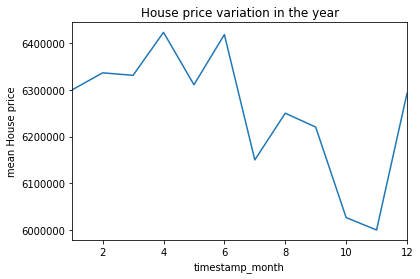

In [129]:
df_train.groupby('timestamp_month')['price_doc'].median().plot()
plt.title('House price variation in the year')
plt.ylabel('mean House price')

In [49]:
x_train['product_type'].unique()

array(['OwnerOccupier', 'Investment'], dtype=object)

In [50]:
x_train.select_dtypes(include='O')

product_type              sub_area culture_objects_top_25  \
id                                                                  
20087  OwnerOccupier           Presnenskoe                    yes   
616       Investment          Dorogomilovo                     no   
19231     Investment               Donskoe                    yes   
27987     Investment        Fili Davydkovo                     no   
13321     Investment           Danilovskoe                     no   
...              ...                   ...                    ...   
1768      Investment         Levoberezhnoe                     no   
12153     Investment        Filevskij Park                     no   
20419  OwnerOccupier  Poselenie Vnukovskoe                     no   
17097     Investment             Rostokino                     no   
11725     Investment             Lianozovo                     no   

      thermal_power_plant_raion incineration_raion oil_chemistry_raion  \
id                                                                       
20087                        no                 no                  no   
616                         yes                 no                  no   
19231                        no                 no                  no   
27987                        no                 no                  no   
13321                       yes                 no                  no   
...                         ...                ...                 ...   
1768                         no                 no                  no   
12153                        no                 no                  no   
20419                        no                 no                  no   
17097                        no                 no                  no   
11725                        no                 no                  no   

      radiation_raion railroad_terminal_raion big_market_raion  \
id                                                               
20087             yes                      no               no   
616               yes                     yes               no   
19231             yes                      no               no   
27987             yes                      no               no   
13321              no                      no               no   
...               ...                     ...              ...   
1768              yes                      no               no   
12153             yes                      no               no   
20419              no                      no               no   
17097              no                      no               no   
11725             yes                      no               no   

      nuclear_reactor_raion detention_facility_raion water_1line  \
id                                                                 
20087                    no                       no          no   
616                      no                       no          no   
19231                    no                       no          no   
27987                    no                       no          no   
13321                    no                       no         yes   
...                     ...                      ...         ...   
1768                     no                       no          no   
12153                    no                       no          no   
20419                    no                       no          no   
17097                    no                       no          no   
11725                    no                       no          no   

      big_road1_1line railroad_1line       ecology  
id                                                  
20087              no             no          poor  
616                no             no          poor  
19231              no            yes          poor  
27987              no             no  satisfactory  
13321              no             no     excellent  
...               ...           

In [71]:
cat_cols=x_train.select_dtypes(include=['O','bool']).columns; cat_cols

Index(['product_type', 'sub_area', 'culture_objects_top_25',
       'thermal_power_plant_raion', 'incineration_raion',
       'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion',
       'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion',
       'water_1line', 'big_road1_1line', 'railroad_1line', 'ecology',
       'timestamp_is_month_start', 'timestamp_is_month_end',
       'timestamp_is_year_end'],
      dtype='object')

In [73]:
x_train.shape

(21330, 299)

In [72]:
len(cat_cols)

18

In [60]:
x_train.select_dtypes(include=['int','float'])

life_sq  floor  max_floor  material  build_year  num_room  kitch_sq  \
id                                                                           
20087    112.0    7.0        9.0       4.0      2017.0       3.0      12.0   
616       16.0    2.0        NaN       NaN         NaN       NaN       NaN   
19231     44.0    5.0       12.0       5.0      1970.0       3.0       9.0   
27987     26.0    1.0        5.0       2.0      1967.0       2.0       5.0   
13321     23.0    9.0        9.0       1.0      1963.0       2.0       7.0   
...        ...    ...        ...       ...         ...       ...       ...   
1768      20.0    NaN        NaN       NaN         NaN       NaN       NaN   
12153     38.0    8.0       17.0       1.0      1989.0       1.0       8.0   
20419     62.0    9.0       17.0       1.0      2014.0       2.0       1.0   
17097     20.0    3.0        5.0       5.0      1966.0       1.0       5.0   
11725     18.0   11.0       17.0       6.0      2005.0       1.0       9.0   

       state        area_m  green_zone_part  ...  green_part_3000  \
id                                           ...                    
20087    1.0  1.163805e+07         0.068202  ...             4.32   
616      NaN  7.798452e+06         0.199431  ...             7.35   
19231    3.0  5.686537e+06         0.073521  ...            10.07   
27987    3.0  6.982964e+06         0.348986  ...            26.65   
13321    3.0  1.249544e+07         0.027651  ...             3.30   
...      ...           ...              ...  ...              ...   
1768     NaN  6.424174e+06         0.216361  ...            15.76   
12153    3.0  9.629358e+06         0.343754  ...            22.78   
20419    1.0  2.553630e+07         0.496315  ...            44.37   
17097    3.0  3.497819e+06         0.146941  ...            31.26   
11725    NaN  5.646405e+06         0.258663  ...            24.81   

       prom_part_3000  cafe_sum_3000_min_price_avg  \
id                                                   
20087           18.10                       986.99   
616              4.09                       974.04   
19231           17.99                       795.78   
27987           12.73                      1075.61   
13321           16.02                       800.95   
...               ...                          ...   
1768             9.60                       576.06   
12153           15.05                      1030.00   
20419            1.97                       680.00   
17097           13.28                       759.77   
11725           16.71                       780.65   

       cafe_sum_3000_max_price_avg  cafe_avg_price_3000  green_part_5000  \
id                                                                         
20087                      1616.76              1301.87            10.43   
616                        1596.40              1285.22            11.20   
19231                      1325.30              1060.54            11.63   
27987                      1780.49              1428.05            19.55   
13321                      1321.85              1061.40             6.26   
...                            ...                  ...              ...   
1768                        985.92               780.99            16.99   
12153                      1714.29              1372.14            19.43   
20419                      1200.00               940.00            35.66   
17097                      1287.36              1023.56            29.49   
11725                      1274.19              1027.42            17.67   

       prom_part_5000  cafe_sum_5000_min_price_avg  \
id                                                   
20087           12.31                       930.94   
616              9.66                       905.79   
19231           12.34                       786.93   
27987           12.57                       943.71   
13321           21.43                       832.36   
...               ...   

In [66]:
num_cols=list(x_train.select_dtypes(include=['int', 'float']).columns)
median_imputer = mdi.MeanMedianImputer(imputation_method='median',variables=num_cols)
median_imputer.fit(x_train)

MeanMedianImputer(imputation_method='median',
                  variables=['life_sq', 'floor', 'max_floor', 'material',
                             'build_year', 'num_room', 'kitch_sq', 'state',
                             'area_m', 'green_zone_part', 'indust_part',
                             'preschool_quota', 'school_quota',
                             'hospital_beds_raion',
                             'raion_build_count_with_material_info',
                             'build_count_block', 'build_count_wood',
                             'build_count_frame', 'build_count_brick',
                             'build_count_monolith', 'build_count_panel',
                             'build_count_foam', 'build_count_slag',
                             'build_count_mix',
                             'raion_build_count_with_builddate_info',
                             'build_count_before_1920', 'build_count_1921-1945',
                             'build_count_1946-1970', 'build_co

In [68]:
len(num_cols)

119

In [70]:
x_train.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O'), dtype('bool')],
      dtype=object)

In [79]:
cats=list(set(x_train.columns)-set(num_cols)); len(cats)

180

In [85]:
x_train[cats].head()

16_29_male  trc_count_1500  0_13_all  16_29_female  \
id                                                          
20087        4834               2     13121          5350   
616          2311               7      4999          2319   
19231        8474               2      6237          9390   
27987       10333               5     13592          8765   
13321       11769               5     10869         12527   

       cafe_count_2000_price_2500  market_count_1000  \
id                                                     
20087                          40                  0   
616                            76                  1   
19231                           9                  0   
27987                           2                  0   
13321                          29                  1   

       ID_railroad_station_avto radiation_raion  young_male  \
id                                                            
20087                        71             yes        7789   
616                          50             yes        2917   
19231                        42             yes        3519   
27987                        22             yes        7766   
13321                        44              no        6137   

       big_church_count_3000  ...  timestamp_month  church_count_5000  \
id                            ...                                       
20087                     13  ...                6                120   
616                       35  ...               12                177   
19231                     15  ...                6                 60   
27987                      4  ...                2                 23   
13321                     45  ...               12                178   

       sport_count_500  female_f  trc_sqm_5000  cafe_count_1500  \
id                                                                
20087                2     32388       3364547              115   
616                  4     11324       3395349              267   
19231                1     51873       2654046               19   
27987                0     41757       1531705               11   
13321                0     54484       3888804               95   

       mosque_count_5000  market_count_3000  cafe_count_1000_na_price  \
id                                                                      
20087                  0                  3                         9   
616                    2                  3                        11   
19231                  0                  2                         0   
27987                  1                  1                         1   
13321                  1                  7                         0   

       culture_objects_top_25  
id                             
20087                     yes  
616                        no  
19231                     yes  
27987                      no  
13321                      no  

[5 rows x 180 columns]

Text(0, 0.5, 'Number of different categories')

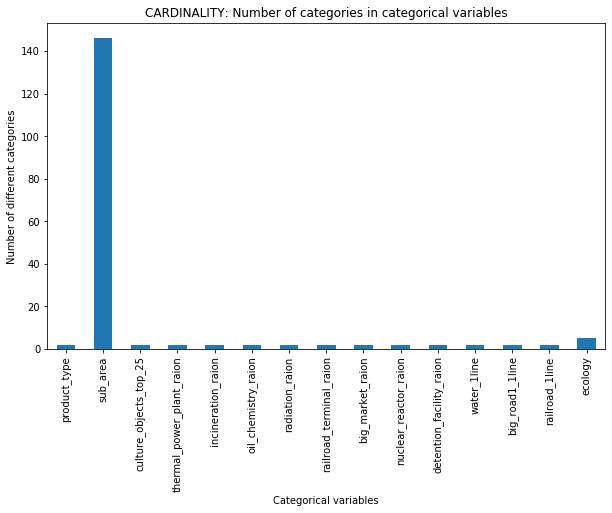

In [131]:
df_train[categorical].nunique().plot.bar(figsize=(10,6))
plt.title('CARDINALITY: Number of categories in categorical variables')
plt.xlabel('Categorical variables')
plt.ylabel('Number of different categories')

In [134]:
x_train[discrete] = x_train[discrete].astype('O')
x_val[discrete] = x_val[discrete].astype('O')

In [143]:
numerical = [var for var in df_train.columns if df_train[var].dtype!='O']
numerical = [var for var in numerical if var not in discrete and var not in ['price_doc']]

In [149]:
pipe = Pipeline([

    # missing data imputation - section 4
    ('missing_ind', mdi.AddNaNBinaryImputer(
        variables=discrete)),
    ('imputer_num', mdi.MeanMedianImputer(imputation_method='mean',
                                          variables=continuous)),
    ('imputer_cat', mdi.CategoricalVariableImputer(variables=categorical+discrete)),

    # categorical encoding - section 6
    ('rare_label_enc', ce.RareLabelCategoricalEncoder(
        tol=0.05, n_categories=6, variables=categorical+discrete)),
    ('categorical_enc', ce.OrdinalCategoricalEncoder(
        encoding_method='ordered', variables=categorical+discrete)),

    # discretisation + encoding
    ('discretisation', dsc.EqualFrequencyDiscretiser(
        q=5, return_object=True, variables=numerical)),
    ('encoding', ce.OrdinalCategoricalEncoder(
        encoding_method='ordered', variables=numerical)),

    # feature Scaling
    ('scaler', StandardScaler()),
    
    # regression
    ('lasso', Lasso(random_state=0))
])

In [150]:
pipe.fit(x_train, y_train)

D:\narain\anaconda3\envs\ml\lib\site-packages\sklearn\utils\validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


TypeError: variable {} is not of type object, check that all indicated variables are of type object before calling the transformer

In [ ]:
x_train_preds=pipe.fit(x_train)
x_val_preds=pipe.fit(x_val)